Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


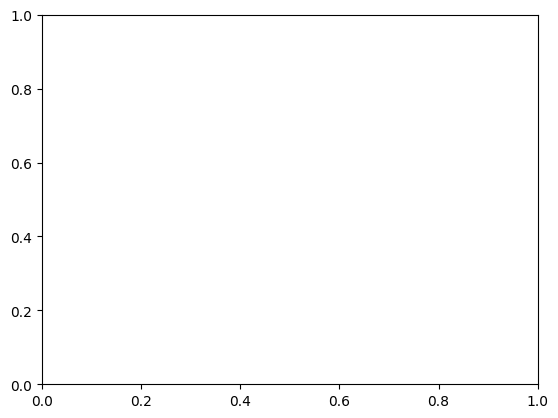

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
plt.grid(False)
%matplotlib inline

import seaborn as sns
sns.set()

from google.colab import drive
drive.mount("/content/gdrive")

In [58]:
df = pd.read_csv('/content/gdrive/MyDrive/solar_irradiation_data.csv')

In [59]:
df = df.dropna(subset = ['GHI_AVG', 'TEMP_AVG', 'HUM_AVG','WDIR_AVG','WSPD_AVG'])
df.describe()

,GHI_AVG,DNI_AVG,WDIR_AVG,WSPD_AVG,TEMP_AVG,HUM_AVG,RAIN_SUM
count,25842.000000,25842.000000,25842.000000,25842.000000,25842.000000,25842.000000,25842.000000
mean,261.468428,305.604844,174.510184,1.388757,21.421420,38.827830,38776.075753
std,350.681499,398.681049,75.716074,4.424704,9.321068,22.312720,103696.380212
min,-6.350522,-4.650700,0.000000,0.000000,-4.173657,4.267947,0.000000
25%,-0.636510,-1.356412,120.185135,0.384553,14.878512,21.659492,0.000000
50%,6.630593,0.000000,161.973918,1.152047,21.852783,33.345202,0.000000
75%,548.069702,767.101214,243.644972,2.155846,28.335655,51.553219,6192.000000
max,1170.911090,1076.749711,700.014391,652.826218,44.854888,99.932081,429120.000000


In [60]:
import random
def create_dataset(X,batch_size,time_steps=1,pred_steps=1):
  Xs,ys = [],[]
  for i in range(batch_size):
    idx = random.randint(0,len(X)-time_steps-pred_steps)
    v = X[idx:idx+time_steps, :]
    u = X[idx+time_steps:idx+time_steps+pred_steps, :]
    Xs.append(v)
    ys.append(u)
  return np.array(Xs), np.array(ys)

In [61]:
from sklearn.preprocessing import MinMaxScaler
def scaler(data):
  scaler = MinMaxScaler(feature_range=(0,1))
  data_use = scaler.fit_transform(data)
  return data_use

In [62]:
df['TIME'] = pd.to_datetime(df['Time'])
df['hour'] = df['TIME'].dt.hour
data_use = scaler(df.iloc[:,[2]])
X = data_use

time_steps = 24*7*4
pred_steps = 24*7*1
X_data, y_data = create_dataset(np.array(X),100,time_steps,pred_steps)

<ipython-input-63-b668b700ffaa>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot = True)


<Axes: >

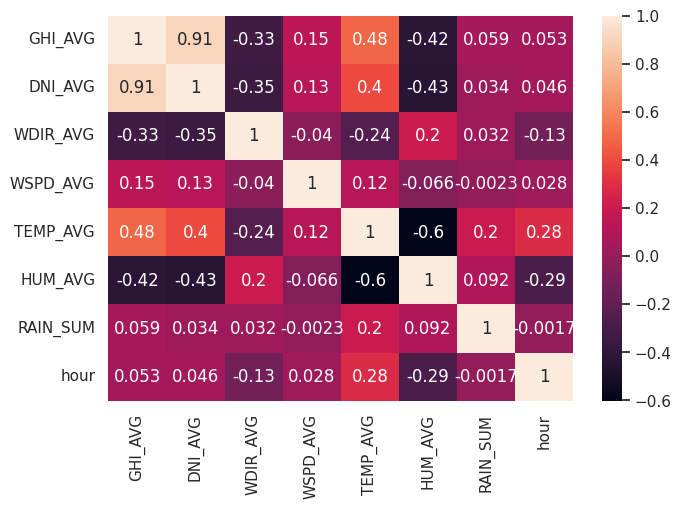

In [63]:
# Correlation heatmap matirx
import seaborn as sns

plt.rcParams['figure.figsize'] = (7.5,5)
sns.heatmap(df.corr(),annot = True)

In [64]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last 28 days time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':168})(x)

model = Model(history_seq, pred_seq_train)

In [65]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 conv1d_8 (Conv1D)           (None, None, 32)          96        
                                                                 
 conv1d_9 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_10 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_11 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_12 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_13 (Conv1D)          (None, None, 32)          2080

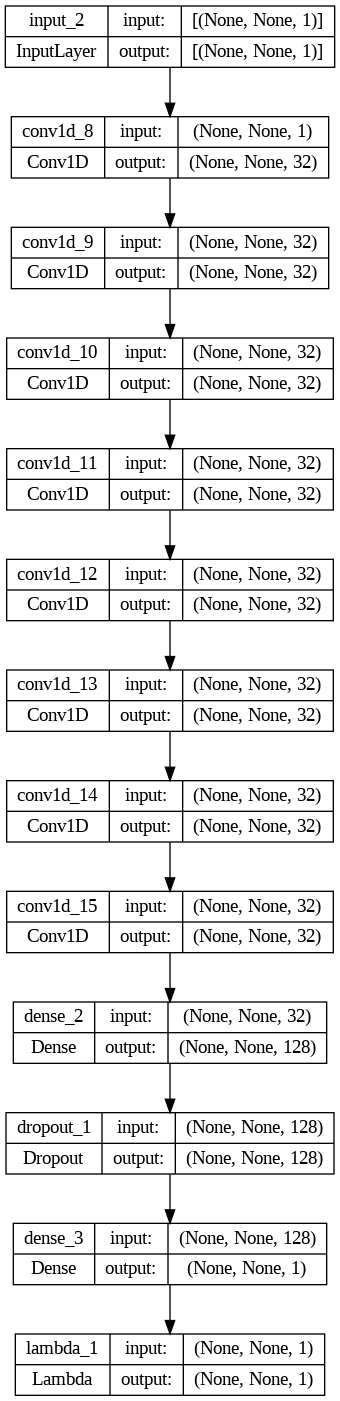

In [66]:
from keras.utils.vis_utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model.png', show_shapes=True)

In [67]:
model.compile(Adam(), loss='mean_absolute_error')
model.fit(X_data,y_data, batch_size=10, epochs=20,validation_split=0.2)

Epoch 1/20
8/8 [==============================] - 5s 272ms/step - loss: 0.2144 - val_loss: 0.1389
Epoch 2/20
8/8 [==============================] - 1s 174ms/step - loss: 0.1173 - val_loss: 0.0698
Epoch 3/20
8/8 [==============================] - 2s 221ms/step - loss: 0.0916 - val_loss: 0.0658
Epoch 4/20
8/8 [==============================] - 2s 254ms/step - loss: 0.0809 - val_loss: 0.0681
Epoch 5/20
8/8 [==============================] - 2s 293ms/step - loss: 0.0768 - val_loss: 0.0622
Epoch 6/20
8/8 [==============================] - 1s 174ms/step - loss: 0.0732 - val_loss: 0.0591
Epoch 7/20
8/8 [==============================] - 1s 178ms/step - loss: 0.0718 - val_loss: 0.0590
Epoch 8/20
8/8 [==============================] - 1s 158ms/step - loss: 0.0711 - val_loss: 0.0628
Epoch 9/20
8/8 [==============================] - 1s 156ms/step - loss: 0.0699 - val_loss: 0.0566
Epoch 10/20
8/8 [==============================] - 1s 157ms/step - loss: 0.0688 - val_loss: 0.0543
Epoch 11/20
8/8 [==

In [68]:
import pandas as pd 

data = pd.DataFrame(columns = ['epochs','loss','val_loss'])

data['epochs'] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

data['loss'] = [0.1599, 
0.0974,
0.0873,
0.0826,
0.0773,
0.0733,
0.0709,
0.0714,
0.0705,
0.0696,
0.0673,
0.0672,
0.0658,
0.0676,
0.0688,
0.0679,
0.0716,
0.0673,
0.0657,
0.0690]

data['val-loss'] = [ 0.0826,
 0.0750,
 0.0787,
 0.0744,
 0.0680,
 0.0680,
 0.0655,
 0.0701,
 0.0640,
 0.0642,
 0.0652,
 0.0642,
 0.0623,
 0.0618,
 0.0624,
 0.0670,
 0.0658,
 0.0618,
 0.0636,
 0.0677]

data = data.drop(['val_loss'],axis=1)
data = data .rename(columns={'val-loss':'val_loss'})
data


,epochs,loss,val_loss
0,1,0.1599,0.0826
1,2,0.0974,0.0750
2,3,0.0873,0.0787
3,4,0.0826,0.0744
4,5,0.0773,0.0680
5,6,0.0733,0.0680
6,7,0.0709,0.0655
7,8,0.0714,0.0701
8,9,0.0705,0.0640
9,10,0.0696,0.0642


In [69]:
import random
def create_dataset_test(X,batch_size,time_steps=1,pred_steps=1):
  Xs,ys = [],[]
  for i in range(batch_size):
    idx = len(X)-time_steps-pred_steps-100
    v = X[idx:idx+time_steps, :]
    u = X[idx+time_steps:idx+time_steps+pred_steps, :]
    Xs.append(v)
    ys.append(u)
  return np.array(Xs), np.array(ys)

In [70]:
X_test, y_test = create_dataset_test(np.array(X),1,time_steps,pred_steps)

In [71]:
pred = model.predict(X_test)

1/1 [==============================] - 0s 308ms/step


In [72]:
pred.shape

(1, 168, 1)

<function matplotlib.pyplot.show(close=None, block=None)>

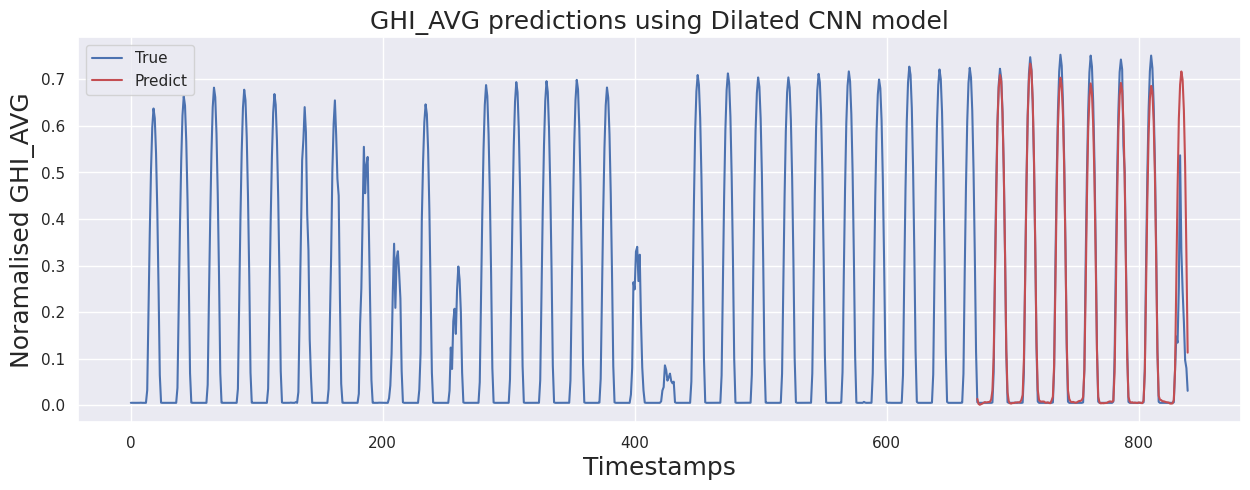

In [73]:
conc = np.concatenate([X_test,y_test],axis=1)
conc = conc.reshape(840,1,1)
conc = conc.reshape(840)
pred = pred.reshape(168,1,1)
pred = pred.reshape(168)

plt.figure(figsize=(15,5))

plt.title('GHI_AVG predictions using Dilated CNN model',fontsize =18)
#Label for x-axis
plt.xlabel("Timestamps",fontsize =18)
# Label for y-axis
plt.ylabel("Noramalised GHI_AVG",fontsize =18)

plt.plot(range(len(conc)), conc, 'b', label = 'True')
plt.plot(range(672,672+168),pred, 'r',label = 'Predict')
plt.legend()

plt.savefig('DCNN_1.png',facecolor ='w')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

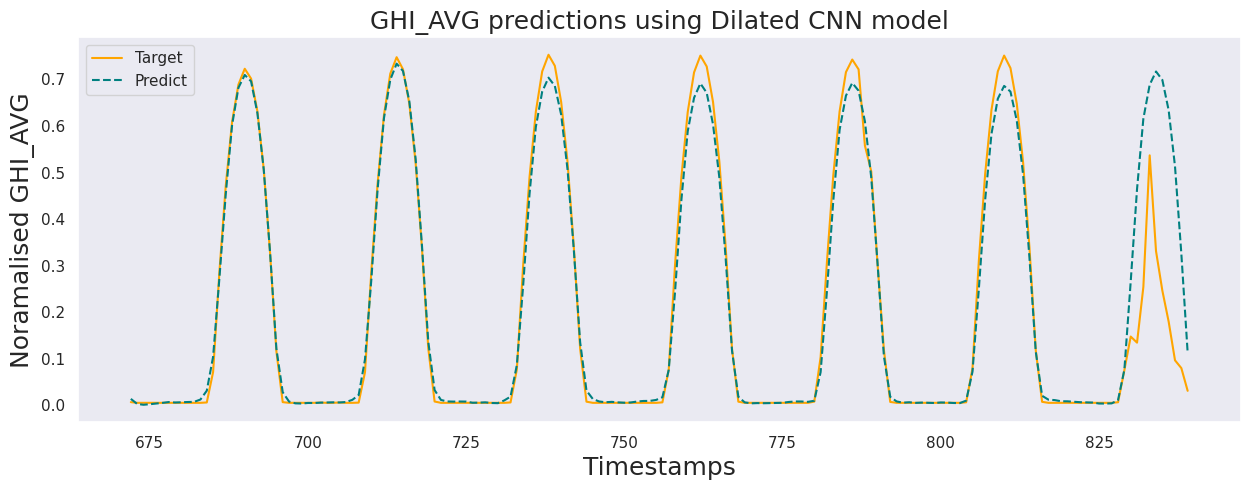

In [74]:
x_encode = time_steps

plt.figure(figsize=(15,5))

plt.title('GHI_AVG predictions using Dilated CNN model',fontsize =18)
#Label for x-axis
plt.xlabel("Timestamps",fontsize =18)
# Label for y-axis
plt.ylabel("Noramalised GHI_AVG",fontsize =18)

# plt.plot(range(0,x_encode),conc[:-168], label = 'True')
plt.plot(range(x_encode,x_encode+pred_steps),conc[-168:],color='orange',label = 'Target')
plt.plot(range(x_encode,x_encode+pred_steps),pred,color='teal',linestyle='--',label = 'Predict')
plt.legend()
plt.style.use('default')
plt.grid(False)
plt.savefig('DCNN_1.png',facecolor ='w')
plt.show

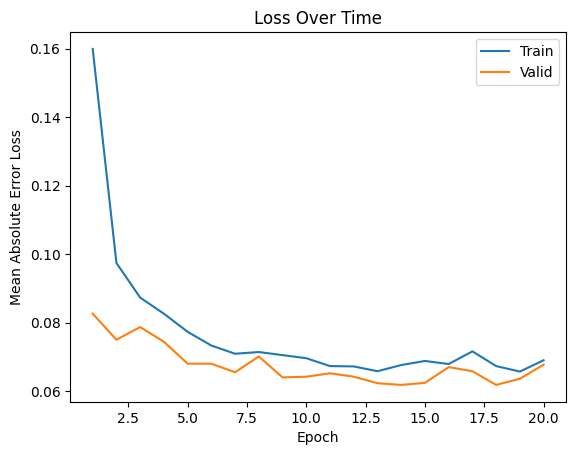

In [75]:
plt.plot(data['epochs'],data['loss'],label = 'Train')
plt.plot(data['epochs'],data['val_loss'],label = 'Valid')

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss') #?!
plt.title('Loss Over Time')
plt.legend()

# Performance Metrics


In [76]:
from sklearn.metrics import r2_score
#calculate r2_score
print(r2_score(conc[-168:],pred))


0.9051818919522469


In [77]:
min_data = X_data.min()
max_data = X_data.min()

In [78]:
from sklearn.metrics import mean_squared_error
from math import sqrt


#calculate RMSE 
print(sqrt(mean_squared_error(conc[-168:],pred)))

0.08303575268638128


In [79]:
from sklearn.metrics import mean_absolute_error

# calculate MAE
print(mean_absolute_error(conc[-168:],pred))

0.03080239511590172


In [80]:
from sklearn.metrics import mean_absolute_percentage_error

# calculate MAPE/MAPD(mean absolute precentaeg deviation)
print(mean_absolute_percentage_error(conc[-168:],pred))

0.47724147020876595


# Save Settings

In [81]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

In [82]:
model.save('DCCNN_model.h5')

In [83]:
# to run the model again, continue frm the point left off
# Restore the weights
# model = create_model()
model.load_weights('./checkpoints/my_checkpoint')

In [84]:
X_test

array([[[0.00545566],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.0054533 ],
        [0.00565032],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00540611],
        [0.03253121],
        [0.19719182],
        [0.36597569],
        [0.50390878],
        [0.59658265],
        [0.63726322],
        [0.61648524],
        [0.54141815],
        [0.41893168],
        [0.25060202],
        [0.06472102],
        [0.00572465],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.03758649],
        [0.21013735],
        [0.38383847],
        [0.52546186],
        [0.62204428],
        [0.66339613],
        [0.64355253],
        [0.56660725],
        [0

In [85]:
y_test

array([[[0.00688318],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00618594],
        [0.07165095],
        [0.28765363],
        [0.47163756],
        [0.60860679],
        [0.68863597],
        [0.72260958],
        [0.70150128],
        [0.63135733],
        [0.50708352],
        [0.327506  ],
        [0.11583777],
        [0.00686902],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.00539432],
        [0.005891  ],
        [0.00539432],
        [0.00545448],
        [0.00607976],
        [0.00539432],
        [0.00539432],
        [0.00584499],
        [0.07119084],
        [0.2870142 ],
        [0.47713054],
        [0.62338331],
        [0.71212386],
        [0.74740819],
        [0.72157021],
        [0.64842023],
        [0

In [86]:
type(X_test)

numpy.ndarray

In [87]:
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/array.txt', 'w') as f:
    np.savetxt(f, X_test)

Mounted at /content/drive


ValueError: ignored